# ABOUT THIS NOTEBOOK
## Purpose
This notebook attempts to fit various machine learning models on the data set.    
Results of the model fitting are analyzed.
## Input
'data_set.pickle' generated by 'data_processing.ipynb'.
## Output
Results of model fitting: parameters and scores.
## Tasks Performed
* Load library packages
* Load pickle file
* Split data into train & test sets
    * Train: weeks 1 & 2, Test: week 3
    * Perform feature scaling
* Implement functions for common tasks
    * Scoring
    * Learning curves
    * Cross validation
    * Hyperparameter selection
* Fit models
    * Linear
    * Random Forest Regressor
    * K-Nearest Neighbors

# LOAD LIBRARY PACKAGES

In [41]:
# Import the required library packages
import os
import re
import timeit

import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn import metrics
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.learning_curve import learning_curve
from sklearn.learning_curve import validation_curve

from six.moves import cPickle as pickle

# Settings for matplotlib, Seaborn
%matplotlib inline
sns.set_style('whitegrid')

# Set font sizes for matplots
plt.rcParams.update({'font.size': 15, 
                     'legend.fontsize': 'medium', 
                     'axes.titlesize': 'medium', 
                     'axes.labelsize': 'medium'})

print 'Read in packages from os, numpy, pandas, matplotlib, seaborn, sklearn & six'

Read in packages from os, numpy, pandas, matplotlib, seaborn, sklearn & six


# LOAD PICKLE FILE

In [16]:
pickle_file = 'data_set.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    pdata_set = save['data_set']
    del save
    print 'Loaded ptrain_set', pdata_set.shape
    
f.close()

Loaded ptrain_set (199584, 55)


In [17]:
pdata_set.columns.values

array(['district_id', 'num_day', 'time_slot', 'week_day', 'demand',
       'demand_t-1', 'demand_t-2', 'demand_t-3', 'supply', 'supply_t-1',
       'supply_t-2', 'supply_t-3', 'gap', 'weather', 'temperature',
       'pollution', 'poi_pc1', 'poi_pc2', 'poi_pc3', 'poi_pc4',
       'poi_cluster', 'tj_lvl1', 'tj_lvl2', 'tj_lvl3', 'tj_lvl4', 'dist_0',
       'dist_1', 'dist_2', 'dist_3', 'dist_4', 'dist_5', 'dist_6',
       'numday_0', 'numday_1', 'numday_2', 'numday_3', 'numday_4', 'ts_0',
       'ts_1', 'ts_2', 'ts_3', 'ts_4', 'ts_5', 'ts_6', 'ts_7', 'weekday_0',
       'weekday_1', 'weekday_2', 'poi_0', 'poi_1', 'poi_2', 'wthr_0',
       'wthr_1', 'wthr_2', 'wthr_3'], dtype=object)

# SPLIT DATA INTO TRAIN & TEST SETS

## Use weeks 1 & 2 for training, week 3 for test

In [18]:
train_days     = range(1,15)
test_days      = range(15, 22)

X_train     = pdata_set[(pdata_set['num_day'].isin(train_days))]
X_test      = pdata_set[(pdata_set['num_day'].isin(test_days))]

print "Shape of X_train, X_test:", X_train.shape, X_test.shape, "\n\n"

Shape of X_train, X_test: (19008, 55) (9504, 55) 




## Generate scaled features for train & test sets

In [19]:
import warnings
warnings.filterwarnings('ignore')

gap_predictors = ['demand_t-1', 'demand_t-2', 'demand_t-3',
                  'supply_t-1', 'supply_t-2', 'supply_t-3',
                  'poi_pc1', 'poi_pc2',
                  'tj_lvl1', 'tj_lvl2', 'tj_lvl3',
                  'ts_0', 'ts_1', 'ts_2', 'ts_3', 'ts_4', 'ts_5', 'ts_6', 'ts_7',
                  'pollution', 'temperature',
                  'wthr_0', 'wthr_1', 'wthr_2', 'wthr_3'
                 ]  

gX_train = []
gy_train = []
gX_test  = []
gy_test  = []

# Use StandardScaler to achieve zero mean and unit variance
# Generate two scalers: input and target
input_scaler = StandardScaler().fit(pdata_set[gap_predictors])
target_scaler = StandardScaler().fit(pdata_set['gap'])

# Scale both training & test data
gX_train  = input_scaler.transform(X_train[gap_predictors])
gy_train  = target_scaler.transform(X_train['gap'])

gX_test = input_scaler.transform(X_test[gap_predictors])
gy_test = target_scaler.transform(X_test['gap'])

# IMPLEMENT FUNCTIONS FOR COMMON TASKS

## Scoring

In [20]:
# Generate Demand Supply Gap Metrics based on provided fit functions
# Assumes expected values for gap is in namesake column
def gap_estimate(**kwargs):
    """
    Generate scores for gap.
    
    Parameters
    ----------
    gX_train  : array containing train features
    gX_test   : array containing test features
    g_fitfunc : function to use for predicting
    """
    
    gX_train     = kwargs["gX_train"]
    gX_test      = kwargs["gX_test"]
    g_fitfunc    = kwargs["g_fitfunc"]
    
    print "\n\nGAP FORECASTING"
    print     "==============="

    # Generate predictions for train & test sets
    gy_pred_train    = target_scaler.inverse_transform(g_fitfunc.predict(gX_train))
    gy_pred_test     = target_scaler.inverse_transform(g_fitfunc.predict(gX_test))

    # Extract expected train & test values
    gy_train    = X_train['gap']
    gy_test     = X_test['gap']

    # Evaluate scores and print results
    print_score(gy_train, gy_pred_train, gy_test, gy_pred_test) 
    return

def print_score(y_train, y_pred_train, y_test, y_pred_test):
    
    """
    Present the MSE, R^2 and MAPE scores for train & test sets as a table.

    Parameters
    ----------
    y_train      : Array containing expected values for train set
    y_pred_train : Array containing predicted values for train set
    y_test       : Array containing expected values for test set
    y_pred_test  : Array containing predicted values for test set
    """
    
    m2score_train    = metrics.mean_squared_error(y_train,    y_pred_train)
    m2score_test     = metrics.mean_squared_error(y_test,     y_pred_test)


    r2score_train    = metrics.r2_score(y_train,    y_pred_train)
    r2score_test     = metrics.r2_score(y_test,     y_pred_test)

    # Assumes data is for 144 time slots, 14 days (train), 7 days (test)
    mpscore_train    = mape_score(y_train,    y_pred_train, ((144*14)-1))
    mpscore_test     = mape_score(y_test,     y_pred_test, ((144*7)-1))


    sets_list = ["TRAIN", "TEST"]

    m2_scores = [m2score_train, m2score_test]
    r2_scores = [r2score_train, r2score_test]
    mp_scores = [mpscore_train, mpscore_test]


    print '\t\tMEAN^2\t\tR2\t\tMAPE'

    for s, m, r, mp in zip(sets_list, m2_scores, r2_scores, mp_scores):
        print '{0:10}\t{1:.2f}\t\t{2:.2f}\t\t{3:.2f}' .format(s, m, r, mp)


def mape_score(exp, pred, q):
    
    """
    Generate the MAPE score value.

    Parameters
    ----------
    exp  : Array containing expected values
    pred : Array containing predicted values
    q    : Constant representing (number of days * number of time slots) - 1
    """
    
    mape = 0.0
    n = 66.0
    
    for gap, gapX in zip(exp, pred):
        if gap > 0:
            mape += 1.0 * abs((gap-gapX)/gap)
    return (mape/(n*q))

In [21]:
# Create a scorer function using the MAPE metric
# Use the training data size (144 time slots * 14 days) for q value

mape_scorer = make_scorer(mape_score, greater_is_better=False, q=((144*14)-1))

## Generate Learning & Validation Curves

In [48]:
def generate_learningcurves(**kwargs):
    ''' Generate learning curves by varying training sizes.
    Use Training vs Cross-validation curves.
    
    Arguments:
    gX_train -- Input features for training
    gy_train -- Target values for training
    alg -- Algorithm used for estimation
    alg_name -- Name of the algorithm
    
    Returns:
    Generates the learning curves plot.
    '''
   
    gX_train      = kwargs["gX_train"]
    gy_train      = kwargs["gy_train"]
    alg           = kwargs["alg"]
    alg_name      = kwargs["alg_name"]
          
    # Plot learning curve
    X, y = gX_train, gy_train
    title = 'Learning Curves for Gap (' + alg_name + ')'

    # Cross validation with 25 iterations to get smoother mean test and train
    # score curves, each time with 20% data randomly selected as a validation set.
    cv = cross_validation.ShuffleSplit(X.shape[0], n_iter=25, test_size=0.2, random_state=0)
    estimator = alg
    plot_learning_curve(estimator, alg_name, title, X, y, cv=cv, n_jobs=-1, train_sizes=np.linspace(.01, 1.0, 20))
    plt.show()
    

        
def plot_learning_curve(estimator, alg_name, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curves.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
                An object of that type which is cloned for each validation.

    alg_name : name of the algorithm being tested
    
    title : string
            Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
           Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
         If an integer is passed, it is the number of folds (defaults to 3).
         Specific cross-validation objects can be passed, see
         sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
             Number of jobs to run in parallel (default 1).
             
    train_sizes : array, optional
                  Sizes of train set to use for generating the learning curve plot 
    """
    # Plot Learning Curve
    plt.figure(figsize=(15,8))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("R^2 Score")
    

    start = timeit.default_timer()
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, 
                                                            n_jobs=n_jobs, train_sizes=train_sizes)
    stop = timeit.default_timer()
    h, m, s = conv_seconds(stop - start)
    print 'Learning Curves Runtime: {0:d}h:{1:02d}m:{2:02d}s\n\n' .format(h, m, s) 
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    
    
    # Print Scores
    for train_size, train_score, test_score in zip(train_sizes, train_scores_mean, test_scores_mean):
        print ('Train Size: {0:7d} Train Score: {1:.3f} Test Score: {2:.3f}' .format(int(train_size), float(train_score), float(test_score)))
    
    return plt


def conv_seconds(seconds):
    '''
    Convert seconds to hours, minutes, seconds format.
    '''
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)
    return (int(h),int(m),int(s))


def plot_validation_curve(estimator, X, y, param_name, param_range, 
                          scoring, plot_title, x_label, y_label, n_jobs=-1):
    """
    Generate a simple plot of the validation curve for one hyperparameter.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
                An object of that type which is cloned for each validation.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    param_name : string with the name of the hyperparameter
    
    param_range : array with values for the hyperparameter
    
    scoring : scoring function to use
    
    plot_title : string
            Title for the chart.
            
    x_label: label for x-axis of the plot
    
    y_label: lable for y-axis of the plot
    
    n_jobs : integer, optional
             Number of jobs to run in parallel (default 1).
    """
    
    # Cross validation with 25 iterations to get smoother mean test and train
    # score curves, each time with 20% data randomly selected as a validation set.
    cv = cross_validation.ShuffleSplit(X.shape[0], n_iter=25, test_size=0.2, random_state=0)
    
    start = timeit.default_timer()
    train_scores, test_scores = validation_curve(estimator, X, y, param_name=param_name, param_range=param_range,
                                                 cv=cv, scoring=scoring, n_jobs=n_jobs)
    stop = timeit.default_timer()
    h, m, s = conv_seconds(stop - start)
    print 'Validation Curves Runtime: {0:d}h:{1:02d}m:{2:02d}s\n\n' .format(h, m, s)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Print Scores
    for param, train_score, test_score in zip(param_range, train_scores_mean, test_scores_mean):
        print ('{0}: {1:7d}    Train Score: {2:.3f} Test Score: {3:.3f}' .format(param_name, int(param), float(train_score), float(test_score)))
    
    plt.figure(figsize=(15,8))
    plt.title(plot_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2, color="r")
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="g")
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color="g")
    plt.legend(loc="best")
    plt.show()

## Select Hyperparameters

In [23]:
def select_hyperparams(**kwargs):
    ''' Perform hyperparameter selection using grid search with 5x2 cross validation.
    Generate learning curves, scores for the best estimator.
    
    Arguments:
    gX_train -- Input features for training
    gy_train -- Target values for training
    gX_test -- Input features for test
    gy_test -- Target values for test
    alg -- Algorithm used for estimation
    alg_name -- Name of the algorithm
    param_grid -- Dictionary with hyperparameters and their range
    scoring_func -- Scoring function for the algorithm
    
    Returns:
    Best estimator found by performing grid search.
    Generates the learning curves, scores for best estimator.
    '''
        
    gX_train      = kwargs['gX_train']
    gy_train      = kwargs['gy_train']
    gX_test       = kwargs["gX_test"]
    gy_test       = kwargs["gy_test"]

    
    alg           = kwargs['alg']
    alg_name      = kwargs['alg_name']
    param_grid    = kwargs['param_grid']
    scoring_func  = kwargs['scoring_func']
    
    start = timeit.default_timer()
    # Use nested cross validation - 5x2 cross validation
    g_gs = GridSearchCV(estimator=alg,
                  param_grid=param_grid,
                  scoring=scoring_func,
                  cv=2,
                  n_jobs=-1)

    stop = timeit.default_timer()
    h, m, s = conv_seconds(stop - start)
    print 'GridSearchCV Runtime: {0:d}h:{1:02d}m:{2:02d}s\n\n' .format(h, m, s)
    
    scores = cross_val_score(estimator=g_gs,
                         X=gX_train,
                         y=gy_train,
                         scoring=scoring_func,
                         cv=5)

    g_gs = g_gs.fit(X=gX_train, y=gy_train)

    print 'Best Estimator:\n', g_gs.best_estimator_
    print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
   
    # Generate Learning Curves
    generate_learningcurves(gX_train=gX_train, gy_train=gy_train,
                            alg=g_gs.best_estimator_, alg_name=alg_name)
    
    # Print All Scores   
    gap_estimate(gX_train=gX_train, gX_test=gX_test, g_fitfunc=g_gs)

# RANDOM FORESTS

## Learning Curves

Learning Curves Runtime: 0h:00m:56s


Train Size:     152 Train Score: 0.877 Test Score: 0.107
Train Size:     944 Train Score: 0.919 Test Score: 0.399
Train Size:    1736 Train Score: 0.927 Test Score: 0.598
Train Size:    2528 Train Score: 0.940 Test Score: 0.694
Train Size:    3321 Train Score: 0.951 Test Score: 0.729
Train Size:    4113 Train Score: 0.956 Test Score: 0.778
Train Size:    4905 Train Score: 0.962 Test Score: 0.793
Train Size:    5698 Train Score: 0.968 Test Score: 0.818
Train Size:    6490 Train Score: 0.963 Test Score: 0.834
Train Size:    7282 Train Score: 0.973 Test Score: 0.826
Train Size:    8075 Train Score: 0.976 Test Score: 0.839
Train Size:    8867 Train Score: 0.977 Test Score: 0.855
Train Size:    9659 Train Score: 0.980 Test Score: 0.860
Train Size:   10452 Train Score: 0.986 Test Score: 0.908
Train Size:   11244 Train Score: 0.986 Test Score: 0.913
Train Size:   12036 Train Score: 0.985 Test Score: 0.909
Train Size:   12829 Train Score: 0.986 Test Score:

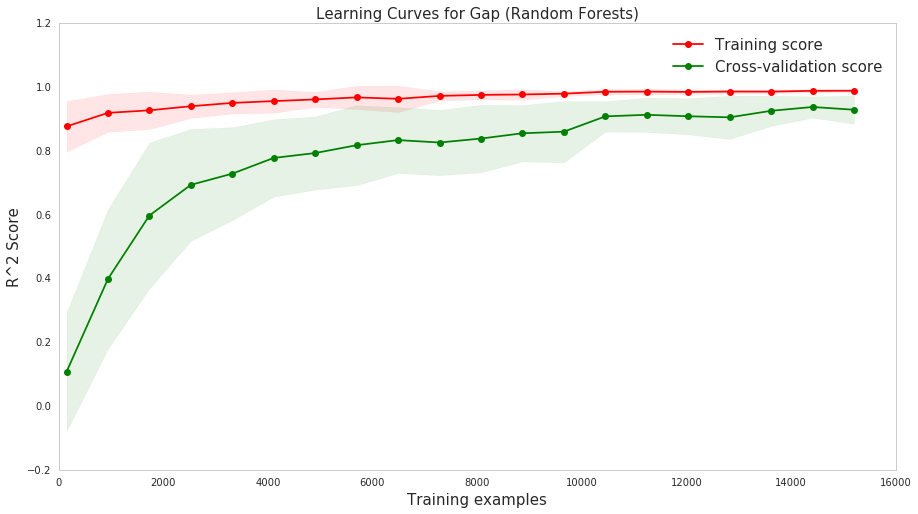

In [49]:
# Random Forests only supports MSE score for deciding splits
generate_learningcurves(gX_train=gX_train, gy_train=gy_train,
                        alg=RandomForestRegressor(), alg_name="Random Forests")

## Validation Curves

n_estimators:       3    Train Score: 0.975 Test Score: 0.904
n_estimators:      10    Train Score: 0.987 Test Score: 0.926


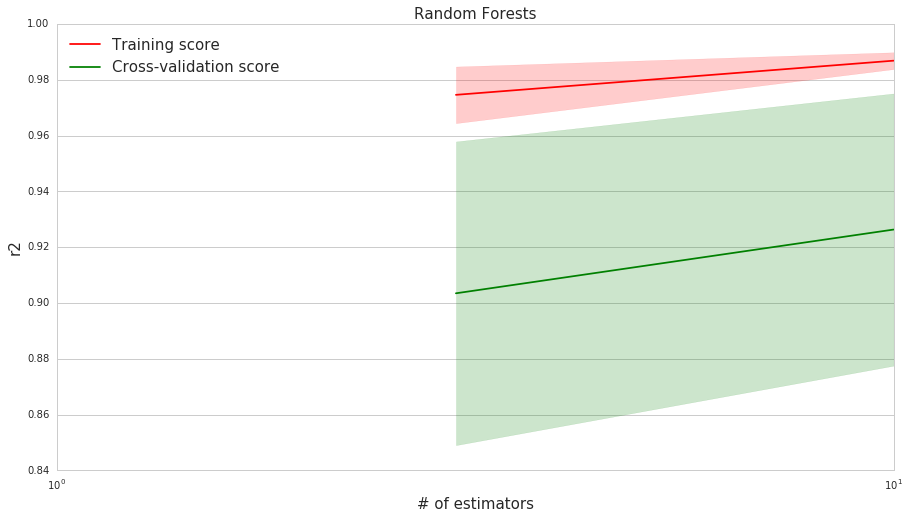

In [37]:
plot_validation_curve(estimator=RandomForestRegressor(), X=gX_train, y=gy_train, 
                      param_name='n_estimators', param_range=[3,10], 
                      scoring='r2', plot_title='Random Forests', x_label='# of estimators', y_label='r2', 
                      n_jobs=-1)

## Hyper Parameter Selection

Best Estimator:
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features=0.75, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=3, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)
CV accuracy: -0.033 +/- 0.022
Train Size:     152 Train Score: 0.854 Test Score: 0.085
Train Size:     944 Train Score: 0.853 Test Score: 0.369
Train Size:    1736 Train Score: 0.874 Test Score: 0.566
Train Size:    2528 Train Score: 0.875 Test Score: 0.675
Train Size:    3321 Train Score: 0.884 Test Score: 0.686
Train Size:    4113 Train Score: 0.880 Test Score: 0.710
Train Size:    4905 Train Score: 0.885 Test Score: 0.717
Train Size:    5698 Train Score: 0.886 Test Score: 0.738
Train Size:    6490 Train Score: 0.886 Test Score: 0.733
Train Size:    7282 Train Score: 0.891 Test Score: 0.740
Train Size:    8075 Train Score: 0.896 Test Score: 0.754
Train Size:    

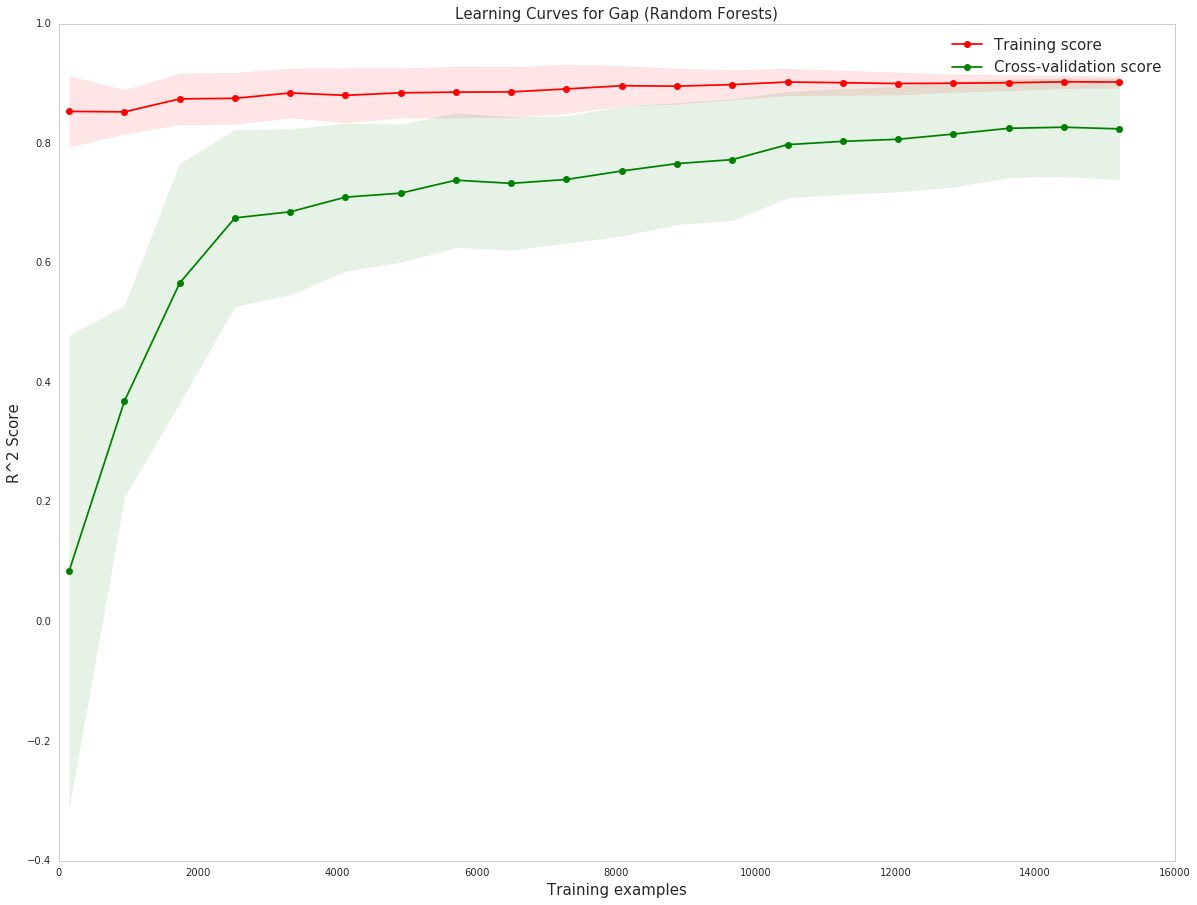



GAP FORECASTING
		MEAN^2		R2		MAPE
TRAIN     	638.81		0.91		0.14
TEST      	665.58		0.65		0.13


In [25]:
# Use GridSearchCV - Demand
# Specify parameters
param_grid = {'n_estimators'      : [50],
              'max_features'      : [0.75, 1.0],
              'max_depth'         : [3],
              'min_samples_split' : [3],
              'random_state'      : [0]}
             
alg = RandomForestRegressor()

# Only mse is supported for the RandomForestRegressor
# Use MAPE as scoring function for GridSearchCV, cross_val_score
select_hyperparams(gX_train=gX_train, gy_train=gy_train, gX_test=gX_test, gy_test=gy_test,
                   alg=alg, alg_name='Random Forests', param_grid=param_grid, scoring_func=mape_scorer)

# DECISION TREES

## Default Parameters

In [ ]:
# Decision Trees only supports MSE score for deciding splits
generate_learningcurves(gX_train=gX_train, gy_train=gy_train,
                        alg=DecisionTreeRegressor(), alg_name="Decision Trees")

In [ ]:
plot_validation_curve(estimator=KNeighborsRegressor(), X=gX_train, y=gy_train, 
                      param_name='n_neighbors', param_range=[3,10,30,100,300,1000], 
                      scoring='r2', plot_title='KNN', x_label='# of neighbors', y_label='r2', 
                      n_jobs=-1)

## Hyper Parameter Selection

In [ ]:
# Use GridSearchCV - Gap
# Specify parameters
param_grid = {'max_features'      : [0.25, 0.5, 0.75, 1.0],
              'max_depth'         : [5, 10, 15, 20, 25],
              'min_samples_split' : [2, 3, 4, 5, 10],
              'random_state'      : [0]}
             
alg = DecisionTreeRegressor()

# Only mse is supported for the DecisionTreeRegressor
# Use MAPE as scoring function for GridSearchCV, cross_val_score
select_hyperparams(gX_train=gX_train, gy_train=gy_train, gX_test=gX_test, gy_test=gy_test,
                   alg=alg, alg_name='Decision Trees', param_grid=param_grid, scoring_func=mape_scorer)

# K NEAREST NEIGHBORS

## Default Parameters

In [ ]:
# KNN defaults to R^2 score
generate_learningcurves(gX_train=gX_train, gy_train=gy_train,
                        alg=KNeighborsRegressor(), alg_name="KNN")

## Hyper Parameter Selection

In [ ]:
plot_validation_curve(estimator=KNeighborsRegressor(), X=gX_train, y=gy_train, 
                      param_name='n_neighbors', param_range=[3,10,30,100,300,1000], 
                      scoring='r2', plot_title='KNN', x_label='# of neighbors', y_label='r2', 
                      n_jobs=-1)

In [ ]:
# Specify parameters
param_grid = {'n_neighbors'       : [30, 90],
              'weights'           : ['uniform'],
              'metric'            : ['euclidean', 'minkowski']}

alg = KNeighborsRegressor()

# Use MAPE as scoring function
select_hyperparams(gX_train=gX_train, gy_train=gy_train, gX_test=gX_test, gy_test=gy_test,
                   alg=alg, alg_name='KNN', param_grid=param_grid, scoring_func=mape_scorer)

# SUPPORT VECTOR MACHINES

In [ ]:
# SVM defaults to R^2 score
generate_learningcurves(gX_train=gX_train, gy_train=gy_train,
                        alg=SVR(), alg_name="Support Vector Machines")

In [ ]:
# Print Scores   
g_gs = SVR().fit(X=gX_train, y=gy_train)

gap_estimate(gX_train=gX_train, gX_test=gX_test, g_fitfunc=g_gs)

# LINEAR REGRESSION

Learning Curves Runtime: 0h:00m:11s


Train Size:     152 Train Score: 0.965 Test Score: 0.847
Train Size:     944 Train Score: 0.960 Test Score: 0.907
Train Size:    1736 Train Score: 0.970 Test Score: 0.911
Train Size:    2528 Train Score: 0.975 Test Score: 0.914
Train Size:    3321 Train Score: 0.973 Test Score: 0.916
Train Size:    4113 Train Score: 0.973 Test Score: 0.918
Train Size:    4905 Train Score: 0.974 Test Score: 0.918
Train Size:    5698 Train Score: 0.972 Test Score: 0.918
Train Size:    6490 Train Score: 0.972 Test Score: 0.922
Train Size:    7282 Train Score: 0.973 Test Score: 0.922
Train Size:    8075 Train Score: 0.975 Test Score: 0.924
Train Size:    8867 Train Score: 0.974 Test Score: 0.923
Train Size:    9659 Train Score: 0.974 Test Score: 0.924
Train Size:   10452 Train Score: 0.973 Test Score: 0.926
Train Size:   11244 Train Score: 0.973 Test Score: 0.926
Train Size:   12036 Train Score: 0.973 Test Score: 0.926
Train Size:   12829 Train Score: 0.971 Test Score:

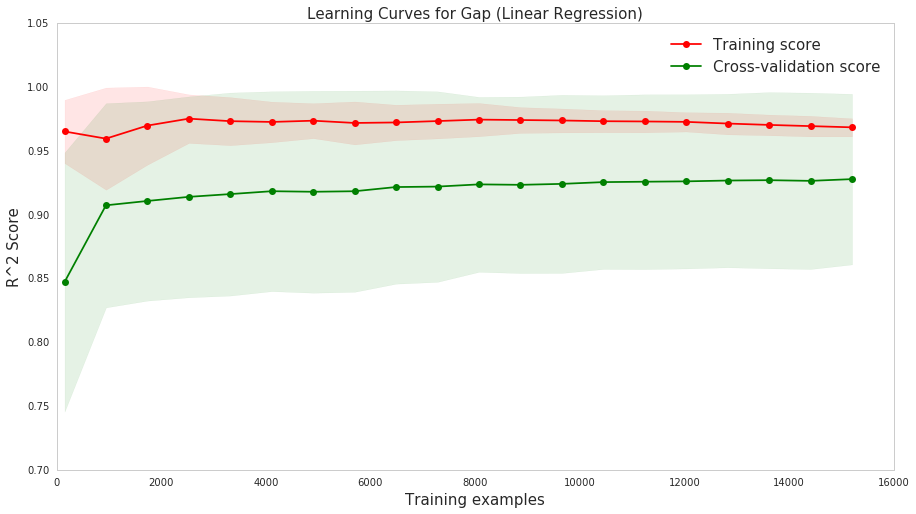

In [50]:
# Linear Regression defaults to R^2 score
generate_learningcurves(gX_train=gX_train, gy_train=gy_train,
                        alg=LinearRegression(), alg_name="Linear Regression")

In [ ]:
# Print Scores   
g_gs = LinearRegression().fit(X=gX_train, y=gy_train)

gap_estimate(gX_train=gX_train, gX_test=gX_test, g_fitfunc=g_gs)

# BENCHMARK - SIMPLE AVERAGE

In [ ]:
# Return simple average of previous 3 time slots
def simple_average(df, t1, t2, t3):
    return df.apply(lambda r: ((r[t1] + r[t2] + r[t3]) / 3.0), axis=1)

# Define list of predictors for demand, supply
r_predictors = ['district_id', 'num_day', 'time_slot', 'demand_t-1', 'demand_t-2', 'demand_t-3'] 
a_predictors = ['district_id', 'num_day', 'time_slot', 'supply_t-1', 'supply_t-2', 'supply_t-3']

# Set arguments for gap forecasting function
kwargs = {"train_set": X_train, "test_set": X_test, 
          "demand_predictors": r_predictors, "supply_predictors": a_predictors,
          "rfit_func": simple_average, "rfit_args": ['demand_t-1','demand_t-2','demand_t-3'],
          "afit_func": simple_average, "afit_args": ['supply_t-1','supply_t-2','supply_t-3']}

gap_forecast(**kwargs)

In [12]:
def analyze_error(gapy_pred_train, gapy_pred_test):
    
    Xerr_train = pd.DataFrame()
    Xerr_test  = pd.DataFrame()
    
    Xerr_train = X_train.copy()
    Xerr_test  = X_test.copy()
    
    # Drop columns that will not be used for analysis
    Xerr_train.drop(['weather', 'temperature', 'pollution', 
                     'demand_t-1', 'demand_t-2', 'demand_t-3', 
                     'supply_t-1', 'supply_t-2', 'supply_t-3'],
                    axis=1, inplace=True)
    
    Xerr_test.drop(['weather', 'temperature', 'pollution', 
                    'demand_t-1', 'demand_t-2', 'demand_t-3', 
                    'supply_t-1', 'supply_t-2', 'supply_t-3'], 
                   axis=1, inplace=True)
    
    
    # Create new columns that store errors
    Xerr_train['gap_error'] = X_train['gap']    - gapy_pred_train
    Xerr_test['gap_error'] = X_test['gap']    - gapy_pred_test
    
    print '\nTrain error correlation matrix:\n', Xerr_train.corr()
    print '\nTest error correlation matrix:\n', Xerr_test.corr()    
  
    print '\nTest Error Joint Plot\n'
    for y in ['demand', 'gap', 'supply', 'district_id', 'num_day', 'time_slot', 'week_day', 'poi_cluster', 'congestion']:
        g = sns.jointplot('gap_error', y, data=Xerr_train, kind="reg",color="r", size=3)
    plt.show()
    
    print '\nTrain Error Joint Plot\n'
    for y in ['demand', 'gap', 'supply', 'district_id', 'num_day', 'time_slot', 'week_day', 'poi_cluster', 'congestion']:
        g = sns.jointplot('gap_error', y, data=Xerr_test, kind="reg",color="r", size=3)
    plt.show()